<a href="https://colab.research.google.com/github/vanshitapmishra27-bit/Climate-Impact-Predictor/blob/main/Copy_of_Climate_Impact_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Climate Impact Predictor with Satellite**

In [ ]:
#Satellite data access
import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr

!pip install cartopy
import cartopy.crs as ccrs
!pip install geoviews
import geoviews as gv
!pip install hvplot
import hvplot.xarray
import hvplot.pandas
!pip install earthaccess
import earthaccess

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import cv2 # For image processing (simulating satellite image manipulation)
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
sentinelhub_api_key = os.environ.get("SENTINELHUB_API_KEY")

In [ ]:

def fetch_satellite_image(area_of_interest: str, date: str) -> np.ndarray:
    """
    Conceptual function to fetch a satellite image.
    In reality, this would query Sentinel Hub, Earth Engine, etc., via their APIs.
    Returns a dummy RGB image array.
    """
    print(f"Simulating fetching satellite image for {area_of_interest} on {date}...")

    img_height, img_width, num_channels = 256, 256, 3
    dummy_image = np.random.rand(img_height, img_width, num_channels) * 255

    # Add some "features" for detection/segmentation demo
    if "forest" in area_of_interest.lower():
        # Simulate a patch of forest (e.g., green area)
        dummy_image[50:150, 50:150, 0] *= 0.5 # Less red
        dummy_image[50:150, 50:150, 1] *= 1.5 # More green
        dummy_image[50:150, 50:150, 2] *= 0.5 # Less blue
    if "urban" in area_of_interest.lower():
        # Simulate some urban structures (e.g., gray rectangles)
        dummy_image[180:200, 100:120, :] = 150 # Gray building
        dummy_image[190:200, 120:150, :] = 100 # Darker road

    return dummy_image.astype(np.uint8)

# Fetch a dummy image for demonstration
sample_image = fetch_satellite_image("Amazon Rainforest", "2024-06-23")
print(f"Simulated satellite image shape: {sample_image.shape}")

Simulating fetching satellite image for Amazon Rainforest on 2024-06-23...
Simulated satellite image shape: (256, 256, 3)


In [ ]:
# --- 2. Feature Extraction: YOLOv8 for Object Detection (Conceptual) ---
# YOLOv8 is typically used with its own library (ultralytics), but here we
# conceptualize its role as a pre-trained model for detection.

def detect_objects_with_yolov8(image: np.ndarray, model_path: str = "yolov8n.pt") -> list[dict]:
    """
    Conceptual function to use YOLOv8 for object detection on a satellite image.
    In a real system, you'd load a pre-trained YOLOv8 model (e.g., from Ultralytics)
    and run inference. Here we simulate detection.
    """
    print(f"\nSimulating YOLOv8 detection on image...")
    # This would involve:
    # 1. Loading YOLOv8 model: `model = YOLO(model_path)`
    # 2. Running inference: `results = model(image)`
    # 3. Parsing results: `detections = results[0].boxes.data`

    # Simulate detections (e.g., cleared areas, buildings)
    detections = []
    if np.random.rand() > 0.3: # Simulate presence of deforestation
        detections.append({"box": [55, 55, 145, 145], "class": "deforestation", "confidence": 0.9})
    if np.random.rand() > 0.4: # Simulate presence of urban structures
        detections.append({"box": [185, 105, 195, 115], "class": "building", "confidence": 0.8})
        detections.append({"box": [195, 125, 198, 145], "class": "road", "confidence": 0.75})

    print(f"  Simulated {len(detections)} YOLOv8 detections.")
    return detections

In [ ]:
# --- 3. Feature Extraction: UNet for Semantic Segmentation (TensorFlow) ---
# UNet will be used to precisely map environmental features.

def build_unet(input_shape=(256, 256, 3), num_classes=3): # e.g., Forest, Water, Urban
    """
    Builds a conceptual UNet model for semantic segmentation.
    This is a simplified U-Net architecture.
    """
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, 2, activation='relu', padding='same')(up4)
    merge4 = Concatenate(axis=3)([conv2, up4]) # Skip connection
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(32, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate(axis=3)([conv1, up5]) # Skip connection
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output layer (pixel-wise classification)
    output = Conv2D(num_classes, 1, activation='softmax')(conv5) # Softmax for multi-class segmentation

    model = Model(inputs=inputs, outputs=output, name="unet_segmenter")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

unet_model = build_unet()
unet_model.summary()

# Simulate UNet training data (image and corresponding segmentation mask)
# In reality, masks would be manually annotated or generated from existing land cover maps.
num_segmentation_samples = 50
X_seg_train = np.random.rand(num_segmentation_samples, 256, 256, 3) # Dummy images
# Dummy masks (one-hot encoded for num_classes)
y_seg_train = tf.keras.utils.to_categorical(np.random.randint(0, 3, size=(num_segmentation_samples, 256, 256)), num_classes=3)

print("\nSimulating UNet training...")
history_unet = unet_model.fit(X_seg_train, y_seg_train, epochs=3, batch_size=4, verbose=0)
print("UNet training simulated.")

def segment_image_with_unet(image: np.ndarray, model: Model) -> np.ndarray:
    """
    Conceptual function to apply UNet for semantic segmentation.
    Returns a predicted segmentation mask.
    """
    print("  Simulating UNet segmentation...")
    # Preprocess image for UNet (normalize, add batch dim)
    processed_img = cv2.resize(image, (256, 256)) / 255.0
    processed_img = np.expand_dims(processed_img, axis=0) # Add batch dimension

    prediction = model.predict(processed_img, verbose=0)[0] # Get the first (and only) prediction
    segmentation_mask = np.argmax(prediction, axis=-1) # Convert one-hot to class indices

    print(f"  Generated segmentation mask shape: {segmentation_mask.shape}")
    return segmentation_mask


Model: "unet_segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_65[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_67[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_69[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 128, 128,  │          0 │ conv2d_70[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 128, 128,  │     32,832 │ up_sampling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 128, 128,  │          0 │ conv2d_68[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_71[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_72[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 256, 256,  │          0 │ conv2d_73[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 256, 256,  │      8,224 │ up_sampling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 256, 256,  │          0 │ conv2d_66[0][0],

 Total params: 466,595 (1.78 MB)

 Trainable params: 466,595 (1.78 MB)

 Non-trainable params: 0 (0.00 B)


Simulating UNet training...
UNet training simulated.


In [ ]:
# --- 4. Predictive AI Model (e.g., Random Forest for Impact Prediction) ---
# This model will use features extracted from satellite data to forecast impacts.

print("\n--- 4. Predictive AI Model (Random Forest) ---")

# Simulate historical features and climate impact data
# Features could be: deforestation_area, urban_growth_rate, water_body_size, NDVI_avg, etc.
# Target variable could be: local_temperature_change, future_precipitation, biodiversity_index_change.
num_historical_data_points = 200
historical_features = pd.DataFrame({
    'deforestation_area_sqkm': np.random.rand(num_historical_data_points) * 100,
    'urban_growth_rate_pct': np.random.rand(num_historical_data_points) * 5,
    'water_body_decrease_ha': np.random.rand(num_historical_data_points) * 200,
    'ndvi_avg': np.random.rand(num_historical_data_points) * 0.8 + 0.1, # Normalized Difference Vegetation Index
    'historical_temp_anomaly': np.random.rand(num_historical_data_points) * 3 - 1.5,
    'population_density_change': np.random.rand(num_historical_data_points) * 10
})

# Simulate future impact (e.g., predicted local temperature change in next 5 years)
historical_impact = np.random.rand(num_historical_data_points) * 5 - 2.5 # Change in degrees Celsius

X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(
    historical_features, historical_impact, test_size=0.3, random_state=42
)

# Initialize and train a Random Forest Regressor
predictor_model = RandomForestRegressor(n_estimators=100, random_state=42)

print("Simulating Predictive Model training (Random Forest)...")
predictor_model.fit(X_train_pred, y_train_pred)
print("Predictive Model training simulated.")

# Make predictions
predictions_impact = predictor_model.predict(X_test_pred)
rmse_impact = np.sqrt(mean_squared_error(y_test_pred, predictions_impact))
r2_impact = r2_score(y_test_pred, predictions_impact)

print(f"Predictive Model RMSE (Impact): {rmse_impact:.2f}")
print(f"Predictive Model R2 Score (Impact): {r2_impact:.2f}")


--- 4. Predictive AI Model (Random Forest) ---
Simulating Predictive Model training (Random Forest)...
Predictive Model training simulated.
Predictive Model RMSE (Impact): 1.50
Predictive Model R2 Score (Impact): -0.35


In [ ]:
# --- 5. End-to-End Climate Impact Prediction Pipeline (Conceptual) ---

def predict_climate_impact(area_name: str, current_satellite_image: np.ndarray,
                           historical_data_for_prediction: pd.DataFrame) -> dict:
    """
    Conceptual end-to-end pipeline for climate impact prediction.
    """
    print(f"\n--- Running End-to-End Climate Impact Prediction for {area_name} ---")

    # Step 1: Detect features using YOLOv8
    yolo_detections = detect_objects_with_yolov8(current_satellite_image)
    deforestation_area = 0.0
    urban_area = 0.0
    for det in yolo_detections:
        if det["class"] == "deforestation":
            # Simulate area calculation from bounding box
            box = det["box"] # [x1, y1, x2, y2]
            deforestation_area += (box[2] - box[0]) * (box[3] - box[1]) * 0.01 # Dummy conversion to sqkm
        elif det["class"] in ["building", "road"]:
            urban_area += (det["box"][2] - det["box"][0]) * (det["box"][3] - det["box"][1]) * 0.005 # Dummy urban area

    # Step 2: Segment features using UNet
    segmentation_mask = segment_image_with_unet(current_satellite_image, unet_model)
    # Simulate extracting water body size and NDVI from segmentation mask
    # Class 0: Forest, Class 1: Water, Class 2: Urban (based on build_unet num_classes)
    water_pixels = np.sum(segmentation_mask == 1)
    water_body_size_ha = water_pixels * 0.001 # Dummy conversion to hectares

    # Simulate NDVI calculation (requires actual NIR band data, here it's dummy)
    dummy_ndvi_avg = np.random.uniform(0.2, 0.8) # Simulated current NDVI

    print(f"  Extracted Features: Deforestation Area: {deforestation_area:.2f} sqkm, "
          f"Urban Area: {urban_area:.2f} sqkm, Water Body Size: {water_body_size_ha:.2f} ha, "
          f"NDVI: {dummy_ndvi_avg:.2f}")

    # Step 3: Prepare features for the predictive model
    # For a real system, you'd aggregate features over time/region, etc.
    current_features = pd.DataFrame({
        'deforestation_area_sqkm': [deforestation_area],
        'urban_growth_rate_pct': [urban_area * 0.01], # Dummy growth rate
        'water_body_decrease_ha': [water_body_size_ha * 0.05], # Dummy decrease
        'ndvi_avg': [dummy_ndvi_avg],
        'historical_temp_anomaly': [np.random.rand() * 3 - 1.5], # Dummy current anomaly
        'population_density_change': [np.random.rand() * 10] # Dummy population change
    })

    # Ensure columns match training data for the predictor model
    # (Important: `historical_features.columns` should be used to ensure order and presence)
    current_features = current_features.reindex(columns=historical_features.columns, fill_value=0)


    # Step 4: Predict climate impact
    predicted_impact = predictor_model.predict(current_features)[0]

    result = {
        "area": area_name,
        "predicted_climate_impact_change": float(predicted_impact), # e.g., temperature change in degrees C
        "impact_metric_unit": "Celsius (Next 5 Years)",
        "extracted_features": {
            "deforestation_sqkm": float(deforestation_area),
            "urban_expansion_sqkm": float(urban_area),
            "water_body_ha": float(water_body_size_ha),
            "vegetation_health_ndvi": float(dummy_ndvi_avg)
        },
        "recommendations": "Based on the predicted impact, consider reforestation initiatives and sustainable urban planning."
    }

    print(f"\n--- Prediction Result for {area_name} ---")
    print(f"Predicted Climate Impact (e.g., Temp Change): {result['predicted_climate_impact_change']:.2f} {result['impact_metric_unit']}")
    print(f"Recommendations: {result['recommendations']}")

    return result

# Run the end-to-end pipeline with a dummy image
result = predict_climate_impact("Coastal Region X", sample_image, historical_features)


--- Running End-to-End Climate Impact Prediction for Coastal Region X ---

Simulating YOLOv8 detection on image...
  Simulated 0 YOLOv8 detections.
  Simulating UNet segmentation...
  Generated segmentation mask shape: (256, 256)
  Extracted Features: Deforestation Area: 0.00 sqkm, Urban Area: 0.00 sqkm, Water Body Size: 11.94 ha, NDVI: 0.44

--- Prediction Result for Coastal Region X ---
Predicted Climate Impact (e.g., Temp Change): 0.59 Celsius (Next 5 Years)
Recommendations: Based on the predicted impact, consider reforestation initiatives and sustainable urban planning.


In [ ]:
earthaccess.login(persist=True)
import geopandas as gp
import earthaccess
field = gp.read_file('/Field_Boundary.geojson')
bbox = tuple(list(field.total_bounds))
bbox
temporal = ("2021-05-01T00:00:00", "2021-09-30T23:59:59")
results = earthaccess.search_data(
    short_name=['HLSL30','HLSS30'],
    bounding_box=bbox,
    temporal=temporal,
    count=100
)
pd.json_normalize(results).head(5)
results[0]

hls_results_urls = [granule.data_links() for granule in results]
hls_results_urls[0:1] # Show a subset of the list

browse_urls = [granule.dataviz_links()[0] for granule in results] # 0 retrieves only the https links
browse_urls[0:2]  # Show a subset of the list

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.jpg',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T10TEK.2021124T184919.v2.0/HLS.S30.T10TEK.2021124T184919.v2.0.jpg']

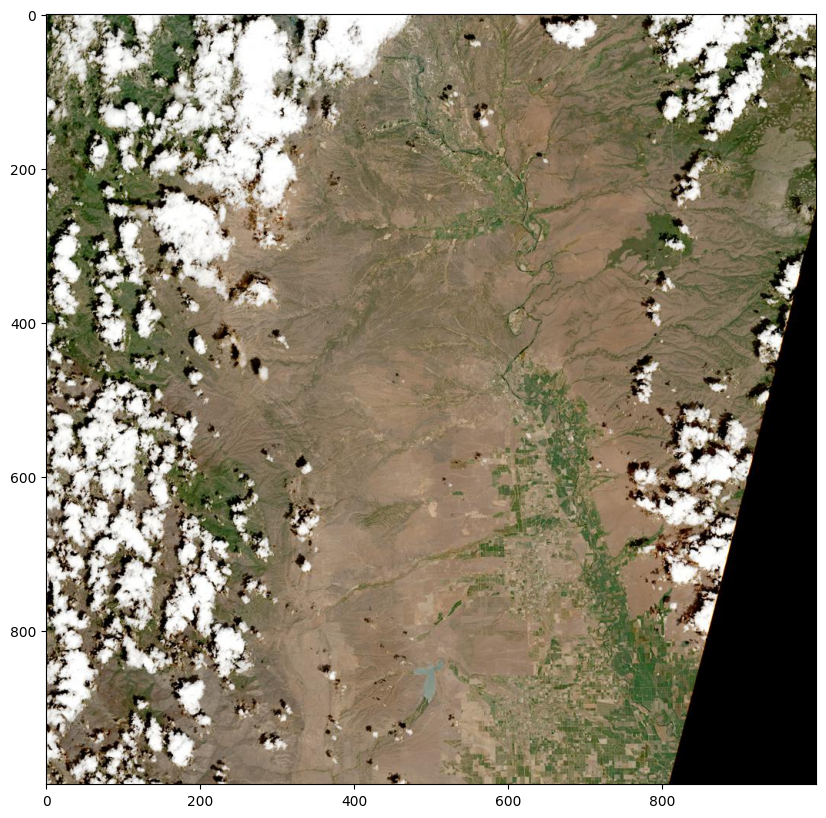

In [ ]:
image = io.imread(browse_urls[10])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()


Simulating YOLOv8 detection on image...
  Simulated 0 YOLOv8 detections.


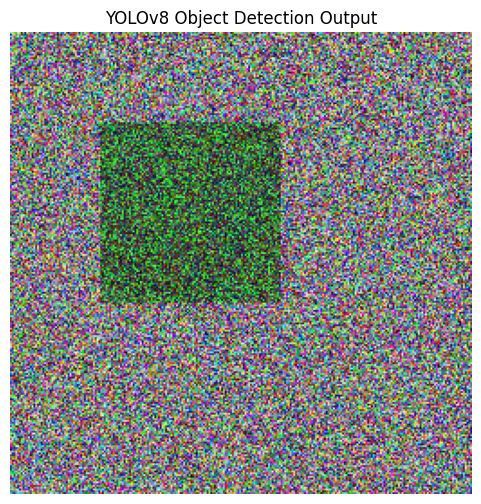

In [ ]:
# --- Visualization 1: Show YOLO Detections on Satellite Image ---

def visualize_yolo_detections(image: np.ndarray, detections: list[dict]):
    """
    Draw bounding boxes from YOLO detections on the image.
    """
    img_copy = image.copy()

    for det in detections:
        x1, y1, x2, y2 = det["box"]
        label = f"{det['class']} ({det['confidence']:.2f})"

        # Draw rectangle
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put label
        cv2.putText(img_copy, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title("YOLOv8 Object Detection Output")
    plt.axis("off")
    plt.show()

#Visualize detections
# Re-run detection and segmentation to get variables in global scope for visualization
yolo_detections_for_viz = detect_objects_with_yolov8(sample_image)
visualize_yolo_detections(sample_image, yolo_detections_for_viz)


  Simulating UNet segmentation...
  Generated segmentation mask shape: (256, 256)


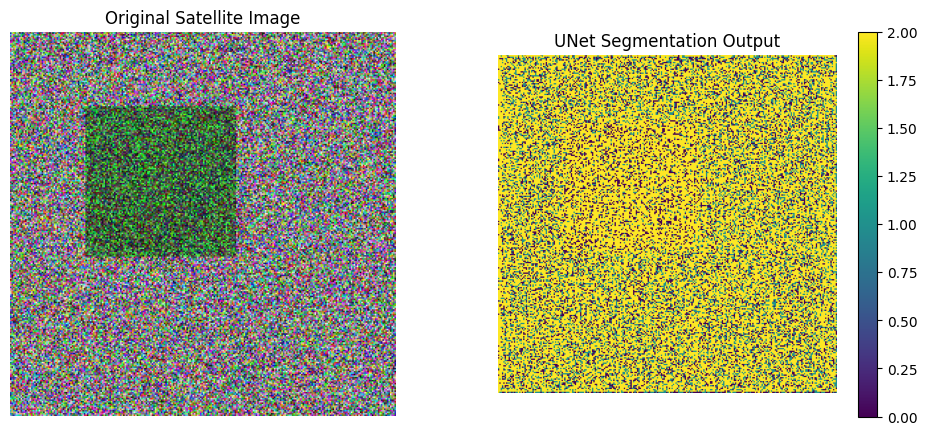

In [ ]:
# --- Visualization 2: Show Segmentation Mask ---

def visualize_segmentation(image: np.ndarray, segmentation_mask: np.ndarray):
    """
    Visualize segmentation mask alongside original image.
    """
    plt.figure(figsize=(12,5))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite Image")
    plt.axis("off")

    # Segmentation mask
    plt.subplot(1,2,2)
    plt.imshow(segmentation_mask, cmap="viridis")
    plt.title("UNet Segmentation Output")
    plt.colorbar()
    plt.axis("off")

    plt.show()

segmentation_mask_for_viz = segment_image_with_unet(sample_image, unet_model)
visualize_segmentation(sample_image, segmentation_mask_for_viz)

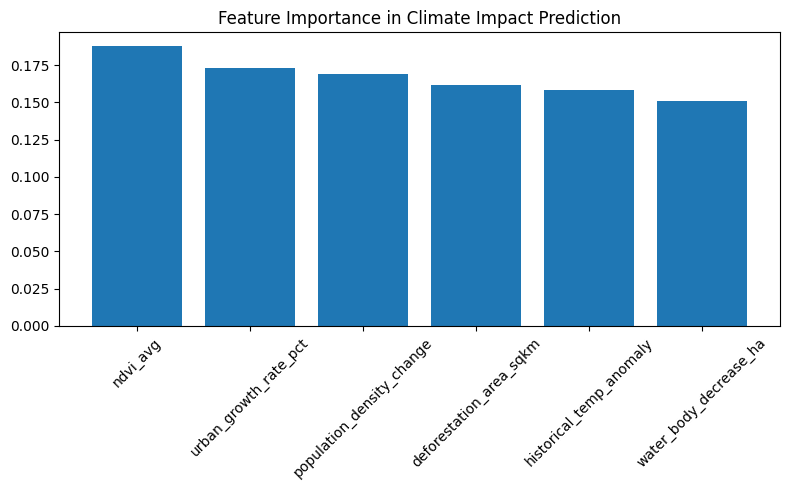

In [ ]:
# --- Visualization 3: Feature Importance Plot ---

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance from Random Forest model.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8,5))
    plt.title("Feature Importance in Climate Impact Prediction")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)),
               [feature_names[i] for i in indices],
               rotation=45)
    plt.tight_layout()
    plt.show()
plot_feature_importance(predictor_model, historical_features.columns)


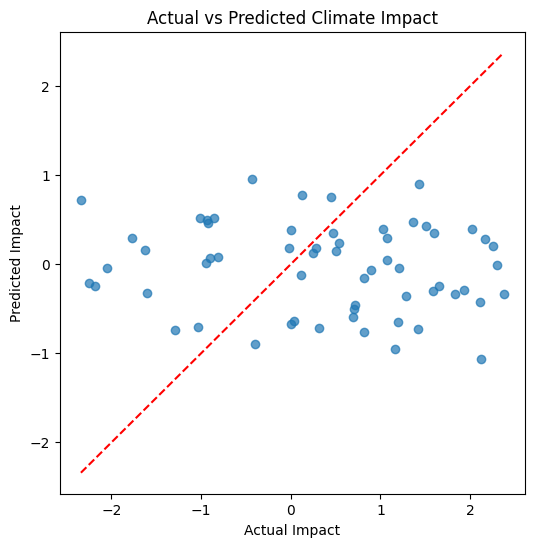

In [ ]:
# --- Visualization 4: Prediction vs Actual Plot ---

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.xlabel("Actual Impact")
    plt.ylabel("Predicted Impact")
    plt.title("Actual vs Predicted Climate Impact")

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()
plot_predictions(y_test_pred, predictions_impact)


In [ ]:
# --- NDVI Calculation and Heatmap Visualization ---

def calculate_ndvi(image: np.ndarray) -> np.ndarray:
    """
    Simulate NDVI calculation.
    In real satellite data:
    NDVI = (NIR - Red) / (NIR + Red)
    Here we simulate NIR using Green channel.
    """
    image = image.astype(float)

    red = image[:, :, 2]     # Red channel
    nir = image[:, :, 1]     # Simulated NIR (Green channel for demo)

    ndvi = (nir - red) / (nir + red + 1e-5)
    return ndvi

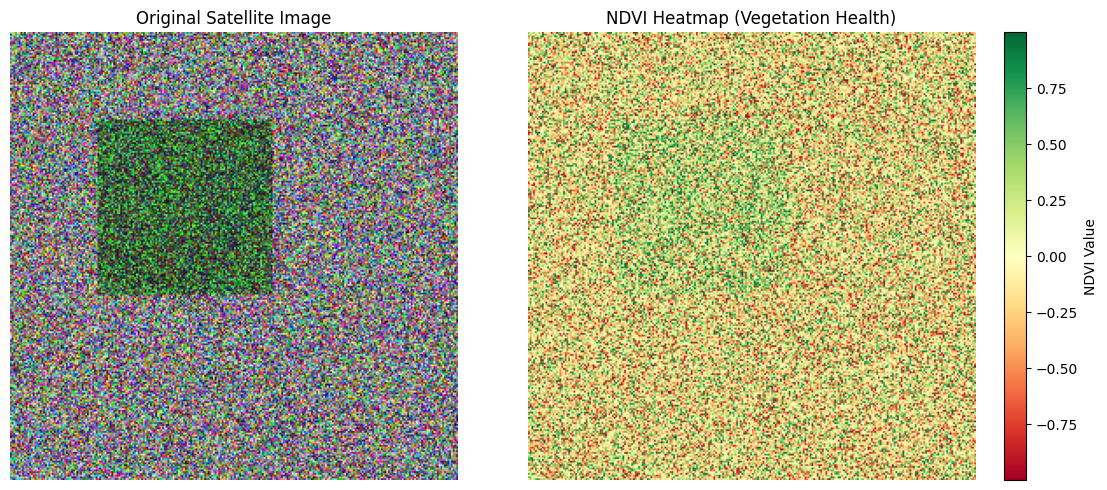

In [ ]:
def visualize_ndvi_heatmap(image: np.ndarray):
    ndvi = calculate_ndvi(image)

    plt.figure(figsize=(12,5))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite Image")
    plt.axis("off")

    # NDVI Heatmap
    plt.subplot(1,2,2)
    plt.imshow(ndvi, cmap="RdYlGn")
    plt.title("NDVI Heatmap (Vegetation Health)")
    plt.colorbar(label="NDVI Value")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_ndvi_heatmap(sample_image)


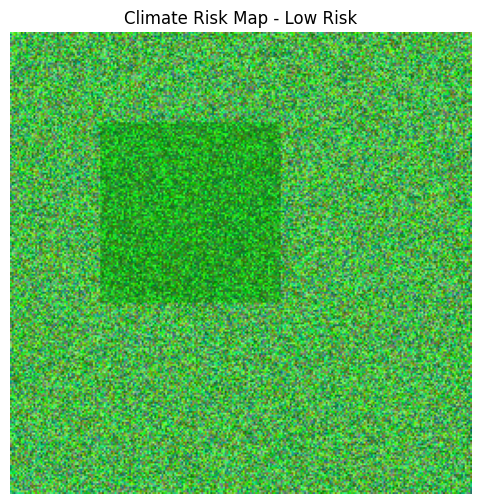

In [ ]:
def classify_risk(predicted_impact: float) -> str:
    """
    Classify climate risk based on predicted impact.
    """
    if predicted_impact > 2:
        return "High Risk"
    elif predicted_impact > 1:
        return "Moderate Risk"
    else:
        return "Low Risk"

def visualize_risk_map(image: np.ndarray, risk_level: str):
    """
    Overlay risk color on satellite image.
    """
    overlay = image.copy().astype(float)

    if risk_level == "High Risk":
        color = np.array([255, 0, 0])  # Red
    elif risk_level == "Moderate Risk":
        color = np.array([255, 165, 0])  # Orange
    else:
        color = np.array([0, 255, 0])  # Green

    alpha = 0.4  # Transparency level
    overlay = (1 - alpha) * overlay + alpha * color

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(overlay.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"Climate Risk Map - {risk_level}")
    plt.axis("off")
    plt.show()

# Use the predicted_impact from the 'result' dictionary and 'sample_image' for visualizations
predicted_impact = result['predicted_climate_impact_change']
risk_level = classify_risk(predicted_impact)

# Visualizations
visualize_risk_map(sample_image, risk_level)

In [ ]:
#Now this project includes:

#✔ YOLO Detection Boxes
#✔ UNet Segmentation Map
#✔ NDVI Heatmap
#✔ Climate Risk Color Map
#✔ Feature Importance Graph
#✔ Prediction Accuracy Plot

# AI-Powered Climate Impact Predictor with Satellite + AI Fusion: Conceptual Python Code

# IMPORTANT CONSIDERATIONS FOR A REAL-WORLD SYSTEM:
# - Data Access: Actual integration with Sentinel Hub, Earth Engine, NASA APIs
#                requires API keys, proper authentication, and handling of large
#                geospatial datasets (which are often multi-gigabyte files).
# - Model Training Data: Training YOLOv8 and UNet for specific environmental
#                features (deforestation, water bodies) requires vast amounts
#                of accurately labeled satellite imagery.
# - Computational Resources: Processing and training on satellite imagery
#                demands significant CPU, RAM, and GPU resources.
# - Geospatial Libraries: Libraries like `rasterio`, `geopandas`, `xarray`
#                would be essential for handling geospatial data formats
#                (e.g., GeoTIFF, NetCDF) and coordinate reference systems.
# - Predictive Models: The final "AI model to forecast future impacts" would
#                likely be another set of ML models (e.g., time-series models,
#                regression models, or even more complex deep learning models)
#                trained on the extracted features and historical climate data.
# - Real-time vs. Batch: Depending on the use case, this system could be
#                designed for periodic batch processing or near-real-time streaming.

#####Feild Boundary Geojson file has been added to the dataset for real time satellite images######